## Pre-requisite

- basic knowledge of python;
- basic knowledge of variational approaches;
- basic knowledge of the connection between variational autoencoders and variational approaches; readers can read [https://jaan.io/what-is-variational-autoencoder-vae-tutorial](https://jaan.io/what-is-variational-autoencoder-vae-tutorial);
- the jupyter notebook python kernel has installed pyro and pytorch

In [2]:
import pyro
import pyro.distributions as dist

First introduce some terminologies. A **stochastic function** is also called a **model** in pyro, which can be anything as long as with a `__call__` method. **A model describes the process of sampling**. **Primitive stochastic functions**, or distributions, are the basic building blocks of stochastic functions in pyro (here the `dist.Normal`):

In [3]:
x = pyro.sample('x', dist.Normal(0, 1))
print(x)

tensor(0.2784)


Here we create a random variable named "x" which is subject to the normal distribution $N(0, 1)$. A complete list of distributions supported in pyro is [here](https://docs.pyro.ai/en/stable/distributions.html?highlight=pyro.distributions.Cate#module-pyro.distributions.torch).

A model always consists of stochastic function calls and deterministic python code. 
Note that the first argument of `pyro.sample` is the "name" of the random variable/sample statement (also called a **sample site**). It could be used later to identify variables like conditioning:

In [1]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample('measurement', dist.Normal(weight, 0.75))

conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})
print(conditioned_scale(2)) # same interface as scale, still return the sampling of measurement
# note that since its value is already conditioned, the return type is float instead of tensor

9.5


But during sampling, the conditioning would only affect the variables observed. In the following, `weight` is not affected though conditioning on `measurement = 9.5`:

In [40]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample('measurement', dist.Normal(weight, 0.75)), weight

times = 1000
obs_guess = 8.5
mean = 0.
for i in range(times):
    x = scale(obs_guess)[1].item()
    mean += x
    # print(f'{x:.2f}')
mean /= times
print(f'mean: {mean}')

conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

print('<=========== after conditioning ============>')

mean = 0.
for i in range(times):
    x = conditioned_scale(obs_guess)[1].item()
    mean += x
    # print(f'{x:.2f}') 
mean /= times
print(f'mean: {mean}')  # almost the same as pre-conditioning

mean: 8.555059819698334
<=========== after conditioning ============>
mean: 8.493983931541443


Note that:
- theoretically, the mean of weight conditioned on `measurement = 9.5` (with `guess = 8.5`) is 9.14. It's in inference where the conditioning really functions; that is, to sample from a conditioned posterior distribution, you must use inference instead of directly calling the model (See [https://forum.pyro.ai/t/how-does-conditional-inference-works/1526](https://forum.pyro.ai/t/how-does-conditional-inference-works/1526)).
- **A model doesn't need to have a return statement**(the return statement here is for illustration). It just describes the dependencies of random variables and the generative sampling process.  

## Stochastic Variational Inference

For the setting and goal of SVI, pyro tutorial gives a good introduction [here](https://pyro.ai/examples/svi_part_i.html#Setup). Note that: 
- Pyro should be able to compute the log probability of the model and the guide (see below);
- generally speaking the model can have some parameters $\theta$ but since the example here doesn't, we just omit the $\theta$ for $p(\mathbf{x}, \mathbf{z})$. 

The core of SVI is to use a family of parameterized stochastic functions $q_{\phi}(\mathbf{z})$ called **guide** to approximate the posterior distribution of unobserved variables $p(\mathbf{z} | \mathbf{x})$ ; i.e., a special model used to approximate another model M. A guide G for a model M must satisfy the following requirements: 
- has the same argument list as M
- all unobserved variables (unconditioned sample statements) in M must also appear in G (specified by the first argument of `pyro.sample`)
- doesn't have observed sample statements
- Also, guides have learnable parameters $\phi$ which are updated by backprop to approximate the posterior. The general process is as follow:
    - samples the unobserved variables from both the model M and the guide G
    - compute the estimate of the **ELBO** loss from these samples
    - update learnable parameters $\phi$ by backprop

(these are summarized from the official docs, not my personal, biased understanding)

To be more detailed, ELBO is defined as $$ELBO = \mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z})}[\log p(\mathbf{x}, \mathbf{z}) - \log q_{\phi}(\mathbf{z})]$$ Note here $\mathbf{x}$ are the observations and they are fixed. 

Being "stochastic" means that instead of making a intractable computation of the exact ELBO, pyro samples $\mathbf{z}_1, \mathbf{z}_2, \dots, \mathbf{z}_S$ from the guide and use the Monte Carlo estimator: $$\frac{1}{S}\sum_{i=1}^S \log p(\mathbf{x}, \mathbf{z}_i) - \log q_{\phi}(\mathbf{z}_i)$$ So that we can compute the gradient based on this (remember it's a requirement that pyro can compute the log probability from both the model and the guide) and update $\phi$ to make $q_{\phi}(\mathbf{z})$ closer to $p(\mathbf{z}|\mathbf{x})$.

Let's see a complete variational approximate inference example to illustrate how conditioning works:

### A Simple Example

Suppose the posterior distribution we want to approximate is $p_{\theta}(z|x)$, and $q(z)$ is the guide used to approximate; i.e., we want to minimize

KL$\left(q(z)|| p_{\theta}(z|x)\right)$

a =  9.100713729858398
b =  0.5922199487686157


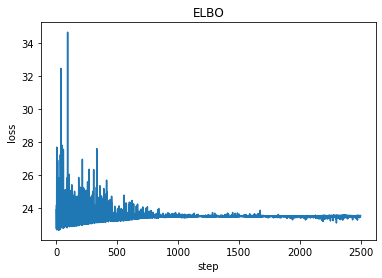

In [51]:
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import torch

def scale():
    guess = pyro.sample('guess', dist.Normal(2.0, 1.0))
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})
conditioned_scale2 = pyro.condition(conditioned_scale, data={'guess': 8.5})

from torch.distributions import constraints
def scale_parametrized_guide():
    a = pyro.param("a", torch.tensor(8.5)) # 8.5 is the initial value for a
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive) # 1 is the initial value for b
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale2,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

Note that:
- though as a model, `conditioned_scale` returns the sampling of `measurement=9.5`, but it actually represents the desired posterior $$p(weight|measurement=9.5, guess=8.5)$$ during the inference.
- Theorectially, $weight|measurement=9.5, guess=8.5 \sim N(9.14, 0.6)$
- We use $$weight \sim N(a, b)$$ to approximate the posterior; `a` and `b` are learnable parameters updated by backprop. This is done by reparameterization $$ weight = a + b\epsilon$$, where $$\epsilon \sim N(0, 1)$$ According to **Universality of the Uniform**, we can do this trick for any distribution whose CDF is continuous and strictly increasing on the support of itself. 
    - But still there are distributions where reparameterization is impossible. For the gradient update of these distributions, see [https://pyro.ai/examples/svi_part_iii.html](https://pyro.ai/examples/svi_part_iii.html)
- All the distributions used here provide an interface `log_prob()` to compute the log probability, so the requirement is fullfilled.
- Here the `constraint` is to ensure that the learnable parameter is a positive number. For a whole list of constraints, see [https://docs.pyro.ai/en/dev/_modules/torch/distributions/constraints.html?highlight=constraints#](https://docs.pyro.ai/en/dev/_modules/torch/distributions/constraints.html?highlight=constraints#)

Generally speaking, 
- learnable parameters of guides <-> `pyro.param` (actually they are wrappers of `torch.Tensor` with `autograd=True`)
- named, unobserved random variables <-> `pyro.sample`
- named, observed random variables <-> `pyro.condition`